# Elliptical lenses: the SIE

The SIE can be derived from the SIS by making the substitution:

$$
\xi \Rightarrow \sqrt{\xi_1^2+f^2\xi_2^2}
$$

so that

$$
\Sigma(\xi)= \frac{\sigma_v^2}{2G}\frac{\sqrt{f}}{\sqrt{\xi_1^2+f^2\xi_2^2}}
$$

With this substitution, $\Sigma(\xi)$ will be constant on ellipses with minor axis $\xi$ and major axis $\xi/f$, oriented such that the major axis is along the $\xi_2$ axis. In the above formulas, $f=b/a$ is the axis ratio of the ellipses.

By choosing $\xi_0=\xi_{0,SIS}$ as reference scale, and using polar coordinates, we obtain

$$
\kappa(x,\varphi)=\frac{\sqrt{f}}{2x\Delta(\varphi)}
$$

where

$$
\Delta(\varphi)=\sqrt{\cos{\varphi}^2+f^2 \sin{\varphi}^2}
$$

The lensing potential can be found by solving the Poisson equation:

$$
\frac{\partial^2\psi}{\partial x^2}+\frac{1}{x}\frac{\partial\psi}{\partial x}+\frac{1}{x^2}\frac{\partial^2\psi}{\partial \varphi^2}=2\kappa=\frac{\sqrt{f}}{\Delta(\varphi)}
$$

Making the ansatz $\psi(x,\varphi):=x\tilde{\psi}(\varphi)$ and using Green's method, we find

$$
\psi(x,\varphi)=x\frac{\sqrt{f}}{f'}\left[\sin\varphi\arcsin{(f'\sin\varphi)}+\cos\varphi\text{arcsinh}{(f'/f\cos{\varphi})} \right]
$$


(512, 512) (512, 512)


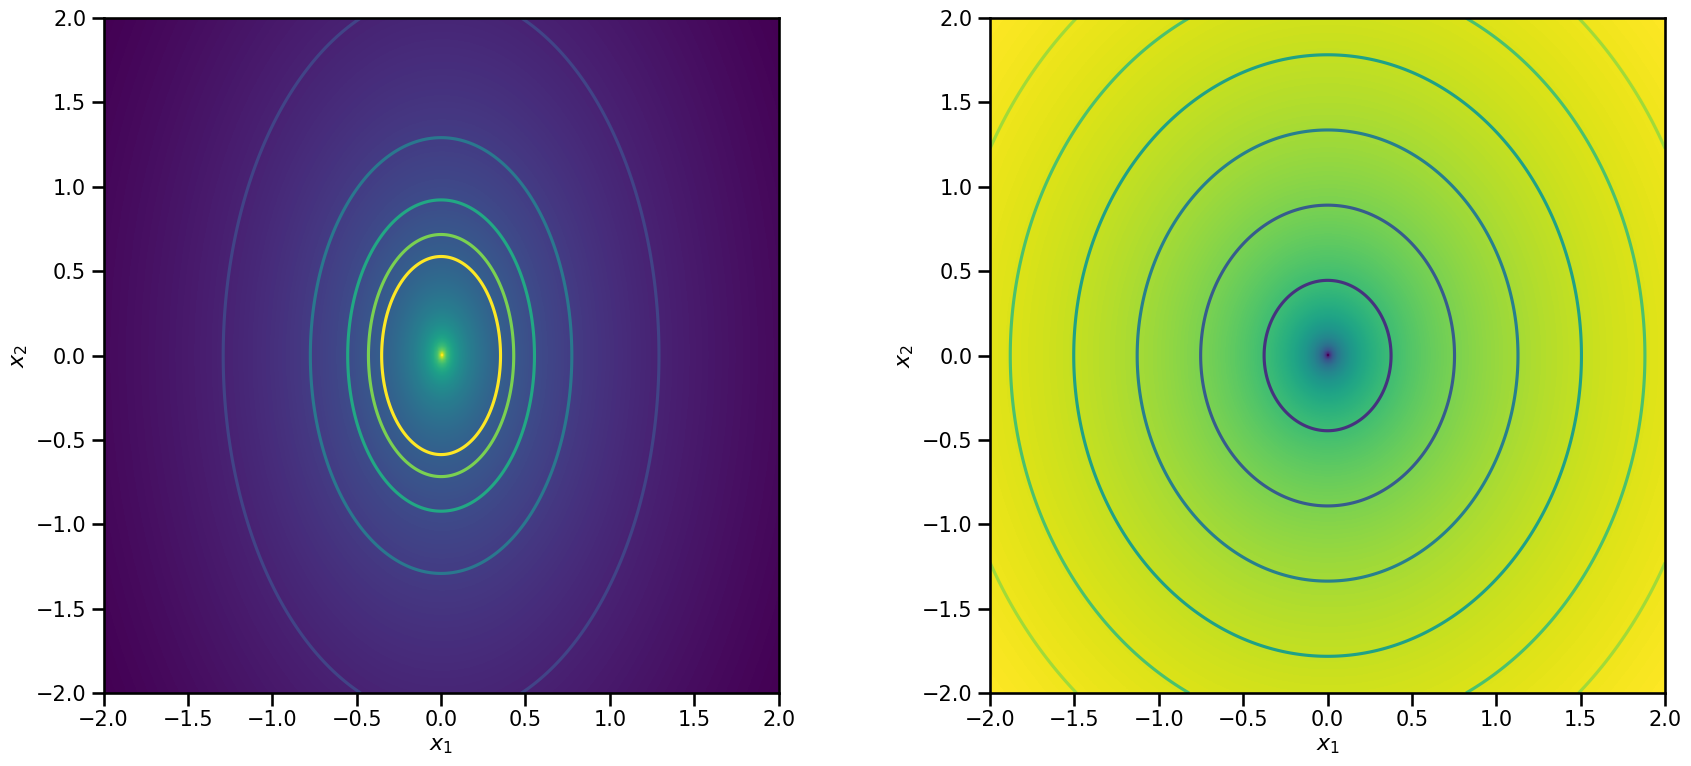

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.patches import Ellipse
from scipy.optimize import fsolve, newton,brenth, brentq
sns.set_context(context="talk")
%matplotlib inline

class sie_lens(object):
    
    def __init__(self,co,sigmav=200,zl=0.3,zs=2.0,f=0.6):
        from astropy.constants import c, G
        self.sigmav=sigmav
        self.co=co
        self.zl=zl
        self.zs=zs
        self.f=f
        self.dl=self.co.angular_diameter_distance(self.zl)
        self.ds=self.co.angular_diameter_distance(self.zs)
        self.dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        xi0=4.0*np.pi*sigmav**2/c**2*self.dl*self.dls/self.ds
    
    def delta(self,f,phi):
        return np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
    
    def kappa(self,x,phi):
        return(np.sqrt(self.f)/2.0/x/self.delta(self.f,phi))
    
    def gamma(self,x,phi):
        return(-self.kappa(x,phi)*np.cos(2.0*phi),
               -self.kappa(x,phi)*np.sin(2.0*phi))
    
    def mu(self,x,phi):
        ga1,ga2=self.gamma(x,phi)
        ga=np.sqrt(ga1*ga1+ga2*ga2)
        return 1.0/(1.0-self.kappa(x,phi)-ga)/(1.0-self.kappa(x,phi)+ga)

    def kappa_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        ka=self.kappa(x,phi)
        print (ka.shape,xk.shape)
        #ka=np.array(ka).reshape([xk.size,yk.size],order='F')
        return(ka)
    
    def psi_tilde(self,phi):
        fp=np.sqrt(1.0-self.f**2)
        return np.sqrt(self.f)/fp*(np.sin(phi)*np.arcsin(fp*np.sin(phi))+
                                   np.cos(phi)*np.arcsinh(fp/f*np.cos(phi)))    

    def psi(self,x,phi):
        psi=x*self.psi_tilde(phi)
        return psi
    
    def pot_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        psi_map=self.psi(x,phi)
        return(np.abs(psi_map))
    
    def alpha(self,phi):
        fp=np.sqrt(1.0-self.f**2)
        a1=np.sqrt(self.f)/fp*np.arcsinh(fp/self.f*np.cos(phi))
        a2=np.sqrt(self.f)/fp*np.arcsin(fp*np.sin(phi))
        return a1,a2
    
    def alpha_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        a1,a2=self.alpha(phi)
        return(a1,a2)
    
    def cut(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        y1,y2=self.alpha(phi)
        return -y1,-y2


    def tan_caustic(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        a1,a2=self.alpha(phi)
        y1=np.sqrt(self.f)/delta*np.cos(phi)-a1
        y2=np.sqrt(self.f)/delta*np.sin(phi)-a2
        return y1,y2  

    def tan_cc(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        r=np.sqrt(self.f)/delta
        x1=r*np.cos(phi)
        x2=r*np.sin(phi)
        return(x1,x2) 
    
    
    def cut_intercept_y1(self):
        s1,y2_tmp=self.alpha(0.0)
        return (s1)

    def cut_intercept_y2(self):
        y1_tmp,s1=self.alpha(np.pi/2.0)
        return (s1)

    def cau_intercept_y1(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)-a1
        return (s1)

    def cau_intercept_y2(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)/self.f-a2
        return (s1)

    def x_ima(self,y1,y2,phi):
        x=y1*np.cos(phi)+y2*np.sin(phi)+(self.psi_tilde(phi))
        return x

    def phi_ima(self,y1,y2,checkplot=True,verbose=True):
        def phi_func(phi):
            a1,a2=self.alpha(phi)
            func=(y1+a1)*np.sin(phi)-(y2+a2)*np.cos(phi)
            return func

        U=np.linspace(0.,2.0*np.pi+0.001,100)
        c = phi_func(U)
        s = np.sign(c)
        phi=[]
        xphi=[]
        for i in range(100-1):
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x=self.x_ima(y1,y2,u)
                if (x>0):
                    phi.append(u)
                    xphi.append(x)
                if (verbose):
                    print('found zero at {}'.format(u))
                    if (x<0):
                        print ('discarded because x is negative ({})'.format(x))
                    else:
                        print ('accepted because x is positive ({})'.format(x))
        if (checkplot):        
            phi_=np.linspace(0.,2.0*np.pi,100)
            ax[0].plot(phi_,phi_func(phi_),label=r'$F(\varphi)$')
            ax[0].plot(phi_,self.x_ima(y1,y2,phi_),label=r'$x(\varphi)$')
            #ax[0].plot(phi_,psi_tilde(phi_,f)-1)
            ax[0].plot(phi,phi_func(phi),'o',markersize=8)
            ax[0].set_xlabel(r'$\varphi$',fontsize=20)
            ax[0].set_ylabel(r'$F(\varphi),x(\varphi)$',fontsize=20)
            ax[0].legend(fontsize=16)
    
        return(np.array(xphi),np.array(phi))

    def ext_source(self,yc1,yc2,rs,npt=720):
        phi=np.linspace(0,2.*np.pi,npt)
        y1=yc1+rs*np.cos(phi)
        y2=yc2+rs*np.sin(phi)
        return(y1,y2)
    
    def ext_image(self,yc1,yc2,rs,npt=720):
        y1,y2=self.ext_source(yc1,yc2,rs,npt)
        x=[]
        phi=[]
        for i in range(len(y1)):
            x_,phi_=self.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)
            for j in range(len(x_)):
                x.append(x_[j])
                phi.append(phi_[j])
        return(x,phi)
            
    
    #utils
    def SigmaCrit(self):
        from astropy.constants import c, G
        c2_G_Msun_Mpc = (c**2/G).to(u.Msun/u.Mpc)
        sigma_cr = c2_G_Msun_Mpc/(4*np.pi)*(self.ds/self.dl/self.dls)
        return(sigma_cr)
    

from astropy.cosmology import FlatLambdaCDM
co = FlatLambdaCDM(H0=70, Om0=0.3)

f=0.6  
xmin=-2
xmax=2
ymin=-2
ymax=2
npix=512

xk=np.linspace(xmin,xmax,npix)
yk=np.linspace(ymin,ymax,npix)

fig,ax=plt.subplots(1,2,figsize=(18,8))

sie=sie_lens(co,f=0.6)
kappa=sie.kappa_map(xk,yk)
ax[0].imshow(kappa,norm=LogNorm(),origin='upper',extent=[xmin,xmax,ymin,ymax])
cs=ax[0].contour(kappa,levels=[0.1,0.3,0.5,0.7,0.9,1.1],extent=[xmin,xmax,ymin,ymax])

pot=sie.pot_map(xk,yk)
ax[1].imshow(pot,norm=LogNorm(),origin='upper',extent=[xmin,xmax,ymin,ymax])
cs=ax[1].contour(pot,extent=[xmin,xmax,ymin,ymax])
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[0].set_xlabel('$x_1$',fontsize=16)
ax[0].set_ylabel('$x_2$',fontsize=16)
ax[1].set_xlabel('$x_1$',fontsize=16)
ax[1].set_ylabel('$x_2$',fontsize=16)

#er=Ellipse((0,0),1.5,1.78,ls='--',color='blue',fill=False)
#er=Ellipse((0,0),3,3.56,ls='--',color='blue',fill=False)
#ax[1].add_artist(er)

plt.tight_layout()
fig.savefig('sie_kappa_pot.png')

The deflection angle can be derived as usual by taking the gradient of the lensing potential. It is convenient to operate in polar coordinates, so that

$$
\frac{\partial}{\partial x_1}=\cos\varphi\frac{\partial}{\partial x}-\frac{\sin\varphi}{x}\frac{\partial}{\partial \varphi}
$$

and 

$$
\frac{\partial}{\partial x_2}=\sin\varphi\frac{\partial}{\partial x}+\frac{\cos\varphi}{x}\frac{\partial}{\partial \varphi}
$$

Then, we obtain

$$
\vec\alpha(\vec x)=\vec\nabla{\psi}=\frac{\sqrt{f}}{f'}\left[\textrm{arcsinh}\left(\frac{f'}{f}\cos\varphi\right),\arcsin(f'\sin\varphi)\right]
$$

As found for the SIS, the deflection angle of the SIE does not depend on $x$. The figures below show how the two components $\alpha_1$ and $\alpha_2$, and the absolute value $\alpha$ depend on the phase $\varphi$.

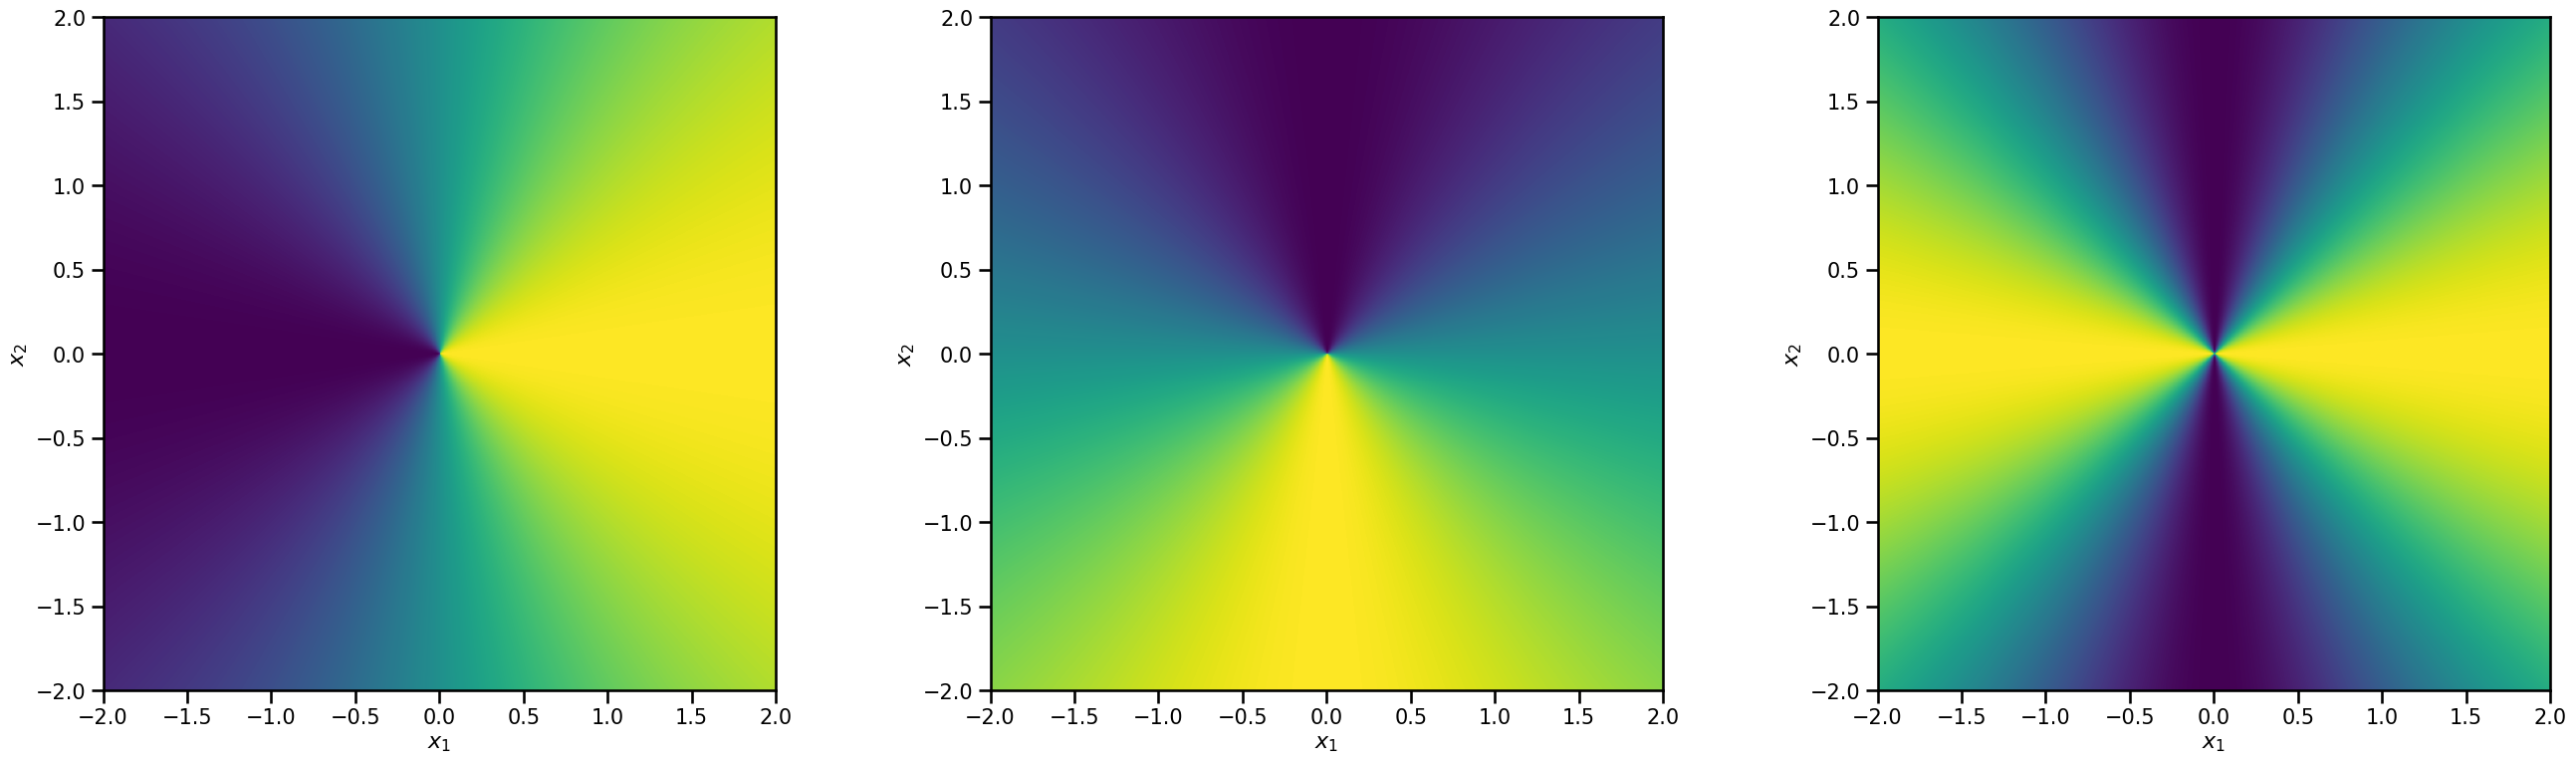

In [2]:
a1,a2=sie.alpha_map(xk,yk)
fig,ax=plt.subplots(1,3,figsize=(27,8))
ax[0].imshow(a1,origin='upper',extent=[xmin,xmax,ymin,ymax])
ax[1].imshow(a2,origin='upper',extent=[xmin,xmax,ymin,ymax])
ax[2].imshow(np.sqrt(a1*a1+a2*a2),origin='upper',extent=[xmin,xmax,ymin,ymax])
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)
ax[0].set_xlabel('$x_1$',fontsize=16)
ax[0].set_ylabel('$x_2$',fontsize=16)
ax[1].set_xlabel('$x_1$',fontsize=16)
ax[1].set_ylabel('$x_2$',fontsize=16)
ax[2].set_xlabel('$x_1$',fontsize=16)
ax[2].set_ylabel('$x_2$',fontsize=16)
plt.tight_layout()

The further step is the derivation of the shear components. These can be derived by means of the derivatives of the deflection angle:

$$
\gamma_1=\frac{1}{2}\left(\frac{\partial\alpha_1}{\partial x_1}-\frac{\partial\alpha_2}{\partial x_2}\right) \\
\gamma_2=\frac{\partial\alpha_1}{\partial x_2}
$$


Using the differential operators in polar coordiantes and the results above, we find that 

$$
\gamma_1=-\frac{\sqrt{f}}{2x\Delta(\varphi)}\cos 2\varphi=-\kappa \cos 2\varphi\\
\gamma_2=-\frac{\sqrt{f}}{2x\Delta(\varphi)}\sin 2\varphi=-\kappa \sin 2\varphi
$$

or, in other words, $\gamma=\kappa$ as for the SIS. Shown below are the maps of the two components of the shear, as well as the map of its absolute value.

Once we have the shear, we can compute the lensing Jacobian. After some math, we can see that

$$
A=\left[ \begin{array}{c} 1-\kappa-\gamma_1 & -\gamma_2 \\ \gamma_2 & 1-\kappa+\gamma_1 \end{array} \right] = \begin{bmatrix} 1-2\kappa\sin^2\varphi & \kappa\sin 2\varphi \\  \kappa\sin 2\varphi & 1-2\kappa\cos^2\varphi \end{bmatrix} 
$$

and that 

$$ 
\lambda_t=1-\kappa-\gamma=1-2\kappa \\
\lambda_r=1-\kappa+\gamma=1
$$

It turns out that, as the SIS, the SIE does not have a critical line, being the radial magnification always unity. The tangential critical line is the ellipse where 

$$
\kappa=\frac{1}{2}
$$

meaning that 
$$
\vec x_t(\varphi)=\frac{\sqrt{f}}{\Delta(\varphi)}\left[\cos\varphi, \sin\varphi\right] \;.
$$

The critical line for the same lens used in the examples above is shown in the right panel below. This line can be mapped onto the source plane using the lens equation, to obtain the tangential caustic:

$$
y_{t,1}=\frac{\sqrt{f}}{\Delta(\varphi)}\cos\varphi-\frac{\sqrt{f}}{f'}\textrm{arcsinh}\left(\frac{f'}{f}\cos\varphi\right)
$$
$$
y_{t,2}=\frac{\sqrt{f}}{\Delta(\varphi)}\sin\varphi-\frac{\sqrt{f}}{f'}\arcsin(f'\sin\varphi)
$$

As for the SIS, we can now search for the **cut**:

$$
\vec y_{c}=\lim_{x\rightarrow 0} \vec y(x,\varphi)=-\vec\alpha(\varphi)
$$

Thus,
$$
y_{c,1}=-\frac{\sqrt{f}}{f'}\textrm{arcsinh}\left(\frac{f'}{f}\cos\varphi\right)
$$
$$
y_{c,2}=-\frac{\sqrt{f}}{f'}\arcsin(f'\sin\varphi)
$$

Both the caustic and the cut are shown below in the left panel (red and blue curves, respectively).

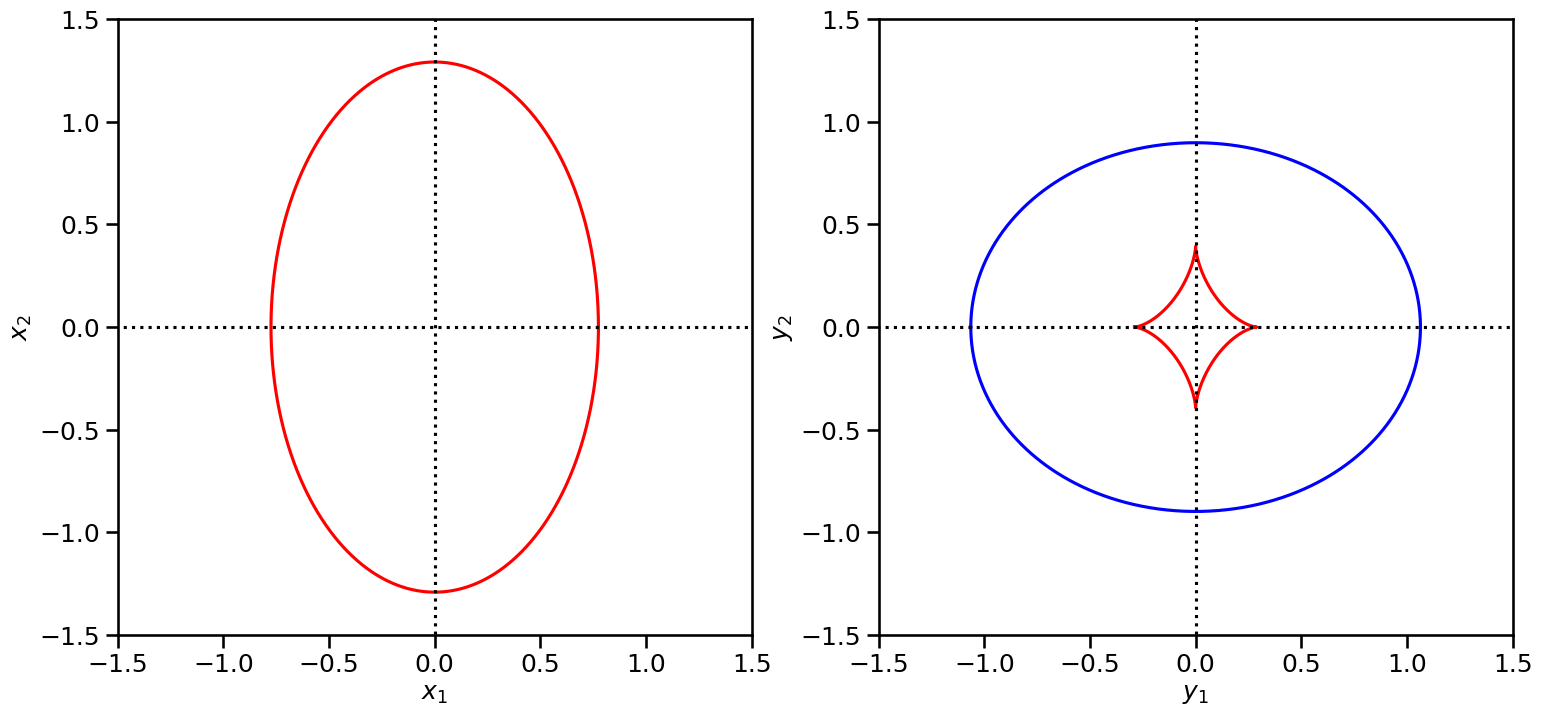

In [3]:
def pol2cart(r,phi):
    x=r*np.cos(phi)
    y=r*np.sin(phi)
    return x,y

def showaxes(ax):
    x=[-100,100]
    y=[0,0]   
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(x,y,':',color='black')
    ax.plot(y,x,':',color='black')
    return

fig,ax=plt.subplots(1,2,figsize=(18,8))
y1_cut,y2_cut=sie.cut()
y1_cau,y2_cau=sie.tan_caustic()
x1_cc,x2_cc=sie.tan_cc()

ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].plot(y1_cut,y2_cut,'-',color='blue')
ax[1].plot(y1_cau,y2_cau,'-',color='red')
ax[0].plot(x1_cc,x2_cc,'-',color='red')

showaxes(ax[0])
showaxes(ax[1])
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.set_tick_params(labelsize=18)

ax[0].set_xlabel('$x_1$',fontsize=18)
ax[0].set_ylabel('$x_2$',fontsize=18)
ax[1].set_xlabel('$y_1$',fontsize=18)
ax[1].set_ylabel('$y_2$',fontsize=18)

fig.savefig('sie_cccau.png')

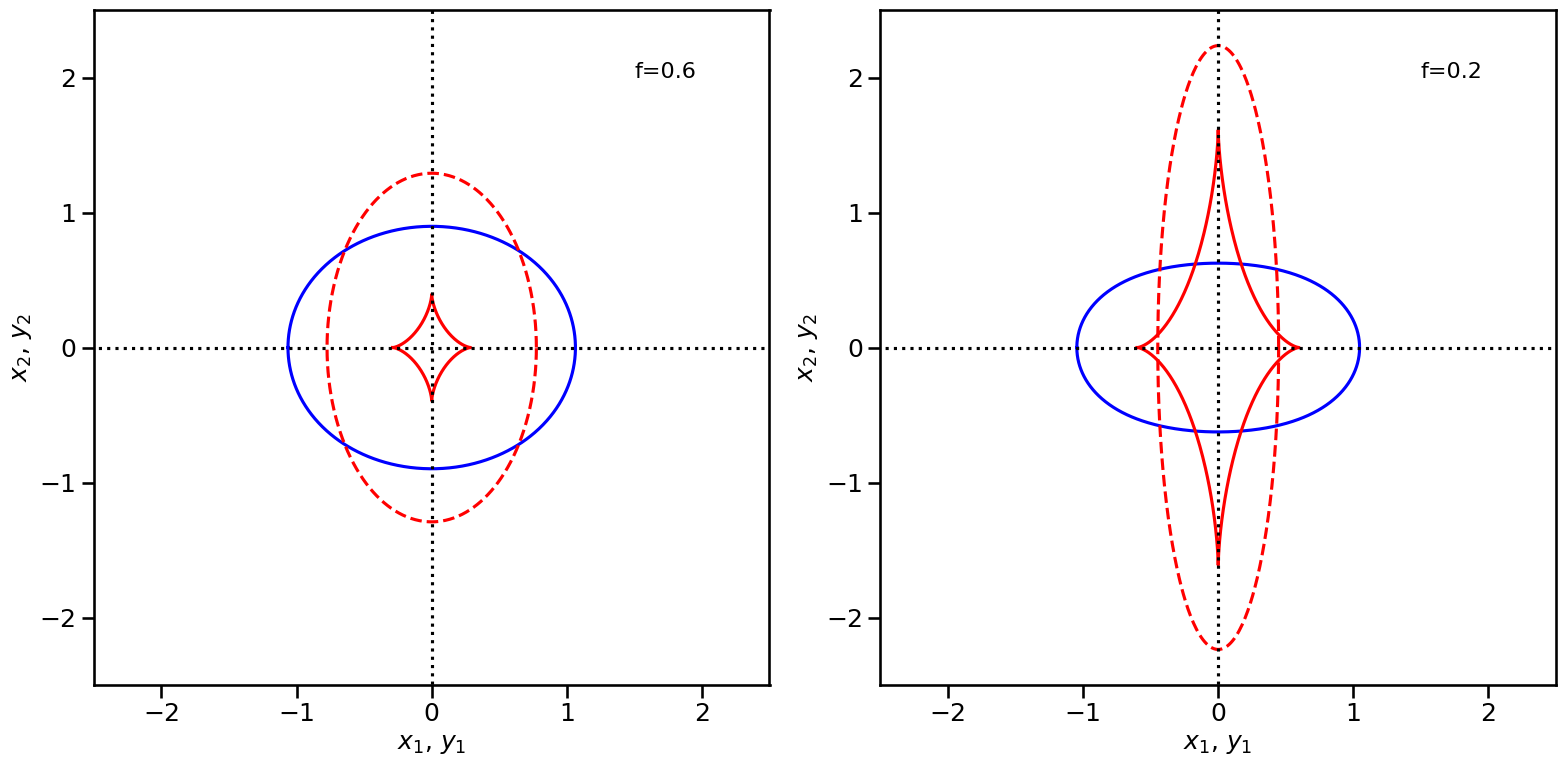

In [4]:
fig,ax=plt.subplots(1,2,figsize=(16,8))
y1_cut,y2_cut=sie.cut()
y1_cau,y2_cau=sie.tan_caustic()
x1_cc,x2_cc=sie.tan_cc()

xmin,xmax=-2.5,2.5

ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([xmin,xmax])
ax[1].set_xlim([xmin,xmax])
ax[1].set_ylim([xmin,xmax])

ax[0].plot(y1_cut,y2_cut,'-',color='blue')
ax[0].plot(y1_cau,y2_cau,'-',color='red')
ax[0].plot(x1_cc,x2_cc,'--',color='red')

sie2=sie_lens(co,f=0.2)
y1_cut,y2_cut=sie2.cut()
y1_cau,y2_cau=sie2.tan_caustic()
x1_cc,x2_cc=sie2.tan_cc()

ax[1].plot(y1_cut,y2_cut,'-',color='blue')
ax[1].plot(y1_cau,y2_cau,'-',color='red')
ax[1].plot(x1_cc,x2_cc,'--',color='red')

showaxes(ax[0])
showaxes(ax[1])
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.set_tick_params(labelsize=18)

ax[0].set_xlabel('$x_1$, $y_1$',fontsize=18)
ax[0].set_ylabel('$x_2$, $y_2$',fontsize=18)
ax[1].set_xlabel('$x_1$, $y_1$',fontsize=18)
ax[1].set_ylabel('$x_2$, $y_2$',fontsize=18)

ax[0].text(1.5,2.0,'f=0.6',fontsize=16)
ax[1].text(1.5,2.0,'f=0.2',fontsize=16)

plt.tight_layout()
fig.savefig('sie_cccau.png')

The cut and the caustic intercept the $y_1$ and the $y_2$ axes in points that are symmetric with respect to the center of the lens. These points have coordinates

$$
y_{c,1}(\varphi=0,\pi)=\pm s_{1,c}\\
y_{c,2}=0
$$

and

$$
y_{c,1}=0 \\
y_{c,2}(\varphi=\pi/2,-\pi/2)=\pm s_{2,c}
$$

for the cut, and 

$$
y_{t,1}(\varphi=0,\pi)=\pm s_{1,t}\\
y_{t,2}=0
$$

and

$$
y_{t,1}=0 \\
y_{t,2}(\varphi=\pi/2,-\pi/2)=\pm s_{2,t}
$$

for the caustic.

The plot below shows $s_1$ and $s_2$ vary as a function of $f$ for both the cut and the caustic. Clearly

$$
s_{1,c}>s_{1,t}
$$

for any $f$, while there exists a value $f=f_0=0.3942$ such that

$$ 
s_{2,c}\leq s_{2,t} \; \textrm{for} \; f \leq f_0 \\
s_{2,c} > s_{2,t} \; \textrm{for}\; f > f_0
$$

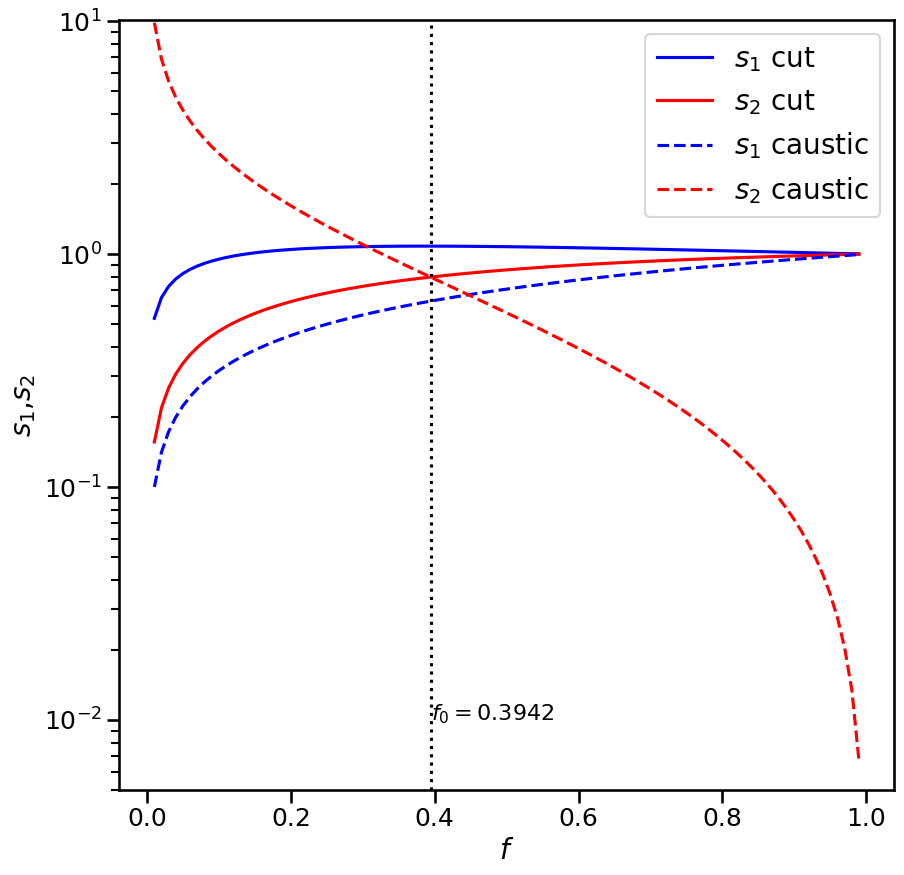

In [5]:
f_arr=np.linspace(0.01,0.99,100)
s1_cut=[]
s2_cut=[]
s1_cau=[]
s2_cau=[]
for f in f_arr:
    sie_=sie_lens(co,f=f)
    s1_cut.append(sie_.cut_intercept_y1())
    s2_cut.append(sie_.cut_intercept_y2())
    s1_cau.append(sie_.cau_intercept_y1())
    s2_cau.append(sie_.cau_intercept_y2())


fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.set_ylim([5e-3,10.1])
ax.plot(f_arr,s1_cut,'-',color='blue',label='$s_1$ cut')
ax.plot(f_arr,s2_cut,'-',color='red',label='$s_2$ cut')
ax.plot(f_arr,s1_cau,'--',color='blue',label='$s_1$ caustic')
ax.plot(f_arr,s2_cau,'--',color='red',label='$s_2$ caustic')
ylim=ax.get_ylim()
ax.plot([0.3942,0.3942],ylim,':',color='black')
ax.set_yscale('log')
ax.legend(loc='best',fontsize=20)
ax.text(0.3942,1e-2,'$f_0=0.3942$',fontsize=16)
ax.set_xlabel('$f$',fontsize=20)
ax.set_ylabel('$s_1$,$s_2$',fontsize=20)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

fig.savefig('sie_s1s2.png')

Thus, when the ellipticity exceeds a certain value, the caustic is no longer fully contained into the cut. This will impact the image multiplicity, as it will be discussed below.

It is important to note how the mapping between the lens and the source plance takes place:

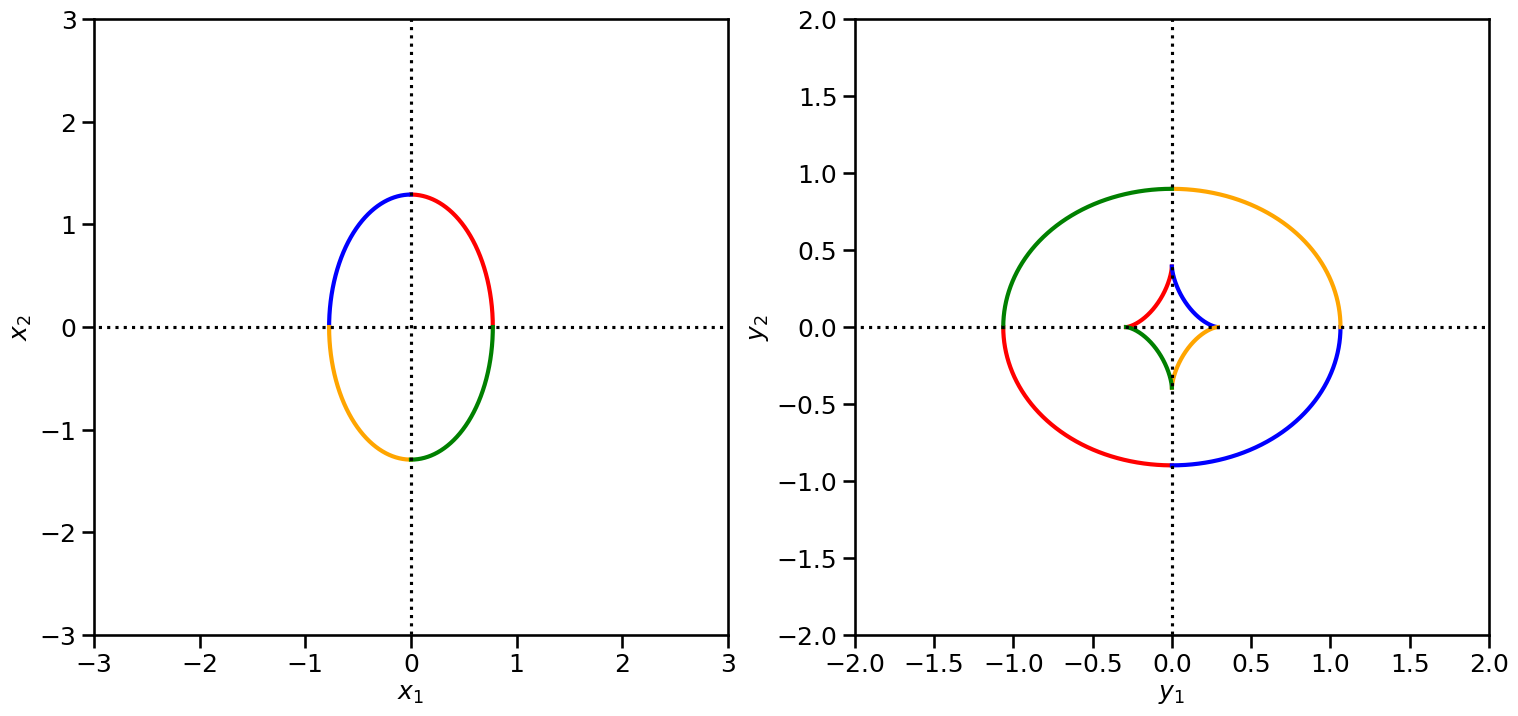

In [6]:
f=0.6
sie=sie_lens(co,f=f)
# first quadrant in the lens plane
fig,ax=plt.subplots(1,2,figsize=(18,8))
y1_cut,y2_cut=sie.cut(0.,np.pi/2.0)
y1_cau,y2_cau=sie.tan_caustic(0.,np.pi/2.0)
x1_cc,x2_cc=sie.tan_cc(0.,np.pi/2.0)

ax[1].plot(y1_cut,y2_cut,'-',color='red',lw=3)
ax[1].plot(y1_cau,y2_cau,'-',color='red',lw=3)
ax[0].plot(x1_cc,x2_cc,'-',color='red',lw=3)

# second quadrant in the lens plane
y1_cut,y2_cut=sie.cut(np.pi/2.0,np.pi)
y1_cau,y2_cau=sie.tan_caustic(np.pi/2.0,np.pi)
x1_cc,x2_cc=sie.tan_cc(np.pi/2.0,np.pi)

ax[1].plot(y1_cut,y2_cut,'-',color='blue',lw=3)
ax[1].plot(y1_cau,y2_cau,'-',color='blue',lw=3)
ax[0].plot(x1_cc,x2_cc,'-',color='blue',lw=3)

# third quadrant in the lens plane
y1_cut,y2_cut=sie.cut(np.pi,1.5*np.pi)
y1_cau,y2_cau=sie.tan_caustic(np.pi,1.5*np.pi)
x1_cc,x2_cc=sie.tan_cc(np.pi,1.5*np.pi)

ax[1].plot(y1_cut,y2_cut,'-',color='orange',lw=3)
ax[1].plot(y1_cau,y2_cau,'-',color='orange',lw=3)
ax[0].plot(x1_cc,x2_cc,'-',color='orange',lw=3)

# fourth quadrant in the lens plane
y1_cut,y2_cut=sie.cut(1.5*np.pi,2*np.pi)
y1_cau,y2_cau=sie.tan_caustic(1.5*np.pi,2*np.pi)
x1_cc,x2_cc=sie.tan_cc(1.5*np.pi,2*np.pi)

ax[1].plot(y1_cut,y2_cut,'-',color='green',lw=3)
ax[1].plot(y1_cau,y2_cau,'-',color='green',lw=3)
ax[0].plot(x1_cc,x2_cc,'-',color='green',lw=3)




ax[1].set_xlim([-2,2])
ax[1].set_ylim([-2,2])
ax[0].set_xlim([-3,3])
ax[0].set_ylim([-3,3])

showaxes(ax[0])
showaxes(ax[1])

ax[0].set_xlabel('$x_1$',fontsize=18)
ax[0].set_ylabel('$x_2$',fontsize=18)
ax[1].set_xlabel('$y_1$',fontsize=18)
ax[1].set_ylabel('$y_2$',fontsize=18)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.set_tick_params(labelsize=18)
    
fig.savefig('sie_caumap.png')

Note the left-right mapping rule for sources near the caustic and the diagonal rule for sources near the cut (of course assuming that the lens major axis is oriented along the $x_2$ axis). This is important for understanding the image parity rule and to understand how to locate counter images.

# Multiple images

Kormann, Bartelmann & Schneider (1994) discuss an approach to find the images of a source lensed by the SIE. Beginning with the lens equation, and multiplying $y_1$ by $\cos\varphi$ and $y_2$ by $\sin\varphi$, the lens equation can be reduced to the one-dimensional equation

$$
y_1\cos\varphi=x_1\cos\varphi-\alpha_1(\vec x)\cos\varphi=x\cos^2\varphi-\alpha(x,\varphi)\cos^2\varphi
$$

$$
y_2\sin\varphi=x_2\sin\varphi-\alpha_2(\vec x)\sin\varphi=x\sin^2\varphi-\alpha(x,\varphi)\sin^2\varphi
$$

$$
\alpha(x,\varphi)=\tilde{\psi} (\varphi)
$$

$$
x=y_1\cos\varphi+y_2\sin\varphi+\tilde{\psi} (\varphi)
$$

By reinserting this equation into the lens equation, we obtain

$$
F(\varphi)=\left[y_1+\frac{\sqrt{f}}{f'}\textrm{arcsinh}\left(\frac{f'}{f}\cos\varphi\right)\right]\sin\varphi-\left[y_2+\frac{\sqrt{f}}{f'}\arcsin(f'\sin\varphi)\right]\cos\varphi=0
$$

Now the problem of finding the images of the source at $(y_1,y_2)$ reduces to the problem of finding the zeros of $F(\varphi)$. Indeed, once $\varphi$ has been determined, it can be inserted in the equation above to obtain $x$. 

The solutions cannot be found analytically: a root finding algorithm such as the Brent's method must be employed.

found zero at 0.5824443522068014
accepted because x is positive (1.7110450026645854)
found zero at 4.152217072183072
accepted because x is positive (0.2609011904101467)


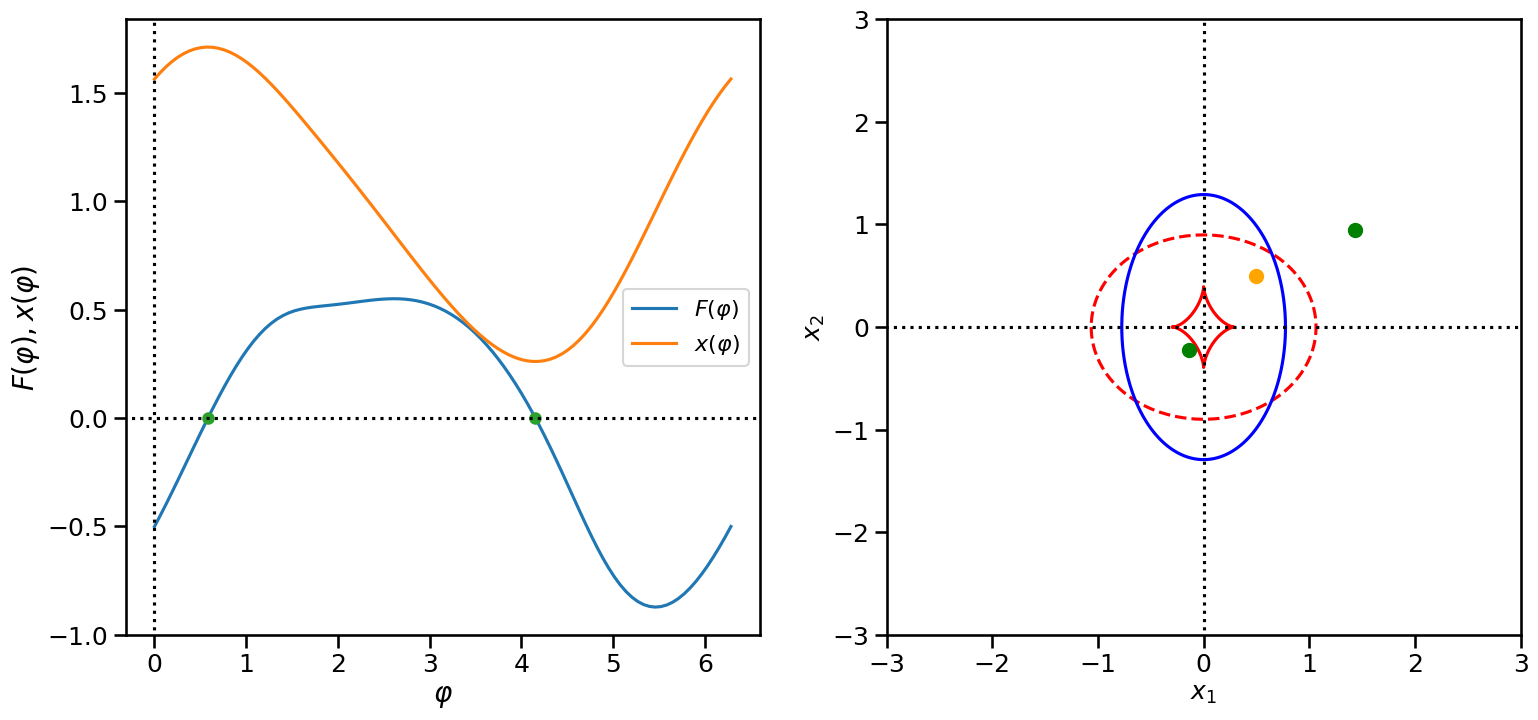

In [7]:
from scipy.optimize import fsolve, newton,brenth, brentq
from sympy import *
import math


fig,ax=plt.subplots(1,2,figsize=(18,8))

y1=0.5
y2=0.5
sie=sie_lens(co,f=0.6)
x,phi=sie.phi_ima(y1,y2)

x1_ima=x*np.cos(phi)
x2_ima=x*np.sin(phi)

y1_cut,y2_cut=sie.cut()
y1_cau,y2_cau=sie.tan_caustic()
x1_cc,x2_cc=sie.tan_cc()

ax[1].set_xlim([-3,3])
ax[1].set_ylim([-3,3])
ax[1].plot(y1_cut,y2_cut,'--',color='red')
ax[1].plot(y1_cau,y2_cau,'-',color='red')
ax[1].plot(x1_cc,x2_cc,'-',color='blue')
showaxes(ax[0])
showaxes(ax[1])

ax[1].plot(y1,y2,'o',markersize=10,color='orange')
ax[1].plot(x1_ima,x2_ima,'o',markersize=10,color='green')

for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.set_tick_params(labelsize=18)
    
ax[1].set_xlabel('$x_1$',fontsize=18)
ax[1].set_ylabel('$x_2$',fontsize=18)
    
fig.savefig('sie_findimages.png')

The two curves in the left panel show the functions $F(\varphi)$ and $x(\varphi;y_1,y_2)$. The zeros of $F$ are marked in red and the corresponding images are shown in the right panel with green circles. Shown are also the caustic (solid-red), the cut (dashed-red) and the critical line (solid-blue). The source position is indicated by the yellow dot. 

Note that some zeros of $F$ are actually spurious solutions and must be rejected. We recongnize them by means of the sign of $x$: whenever it is negative, we reject the solution.

We can now study the multiple image configurations arising from sources at different positions. In the following examples, we consider the case $f>f_0$. We show below the images of sources at different positions, including sources on the cusps and on the folds of the caustic.

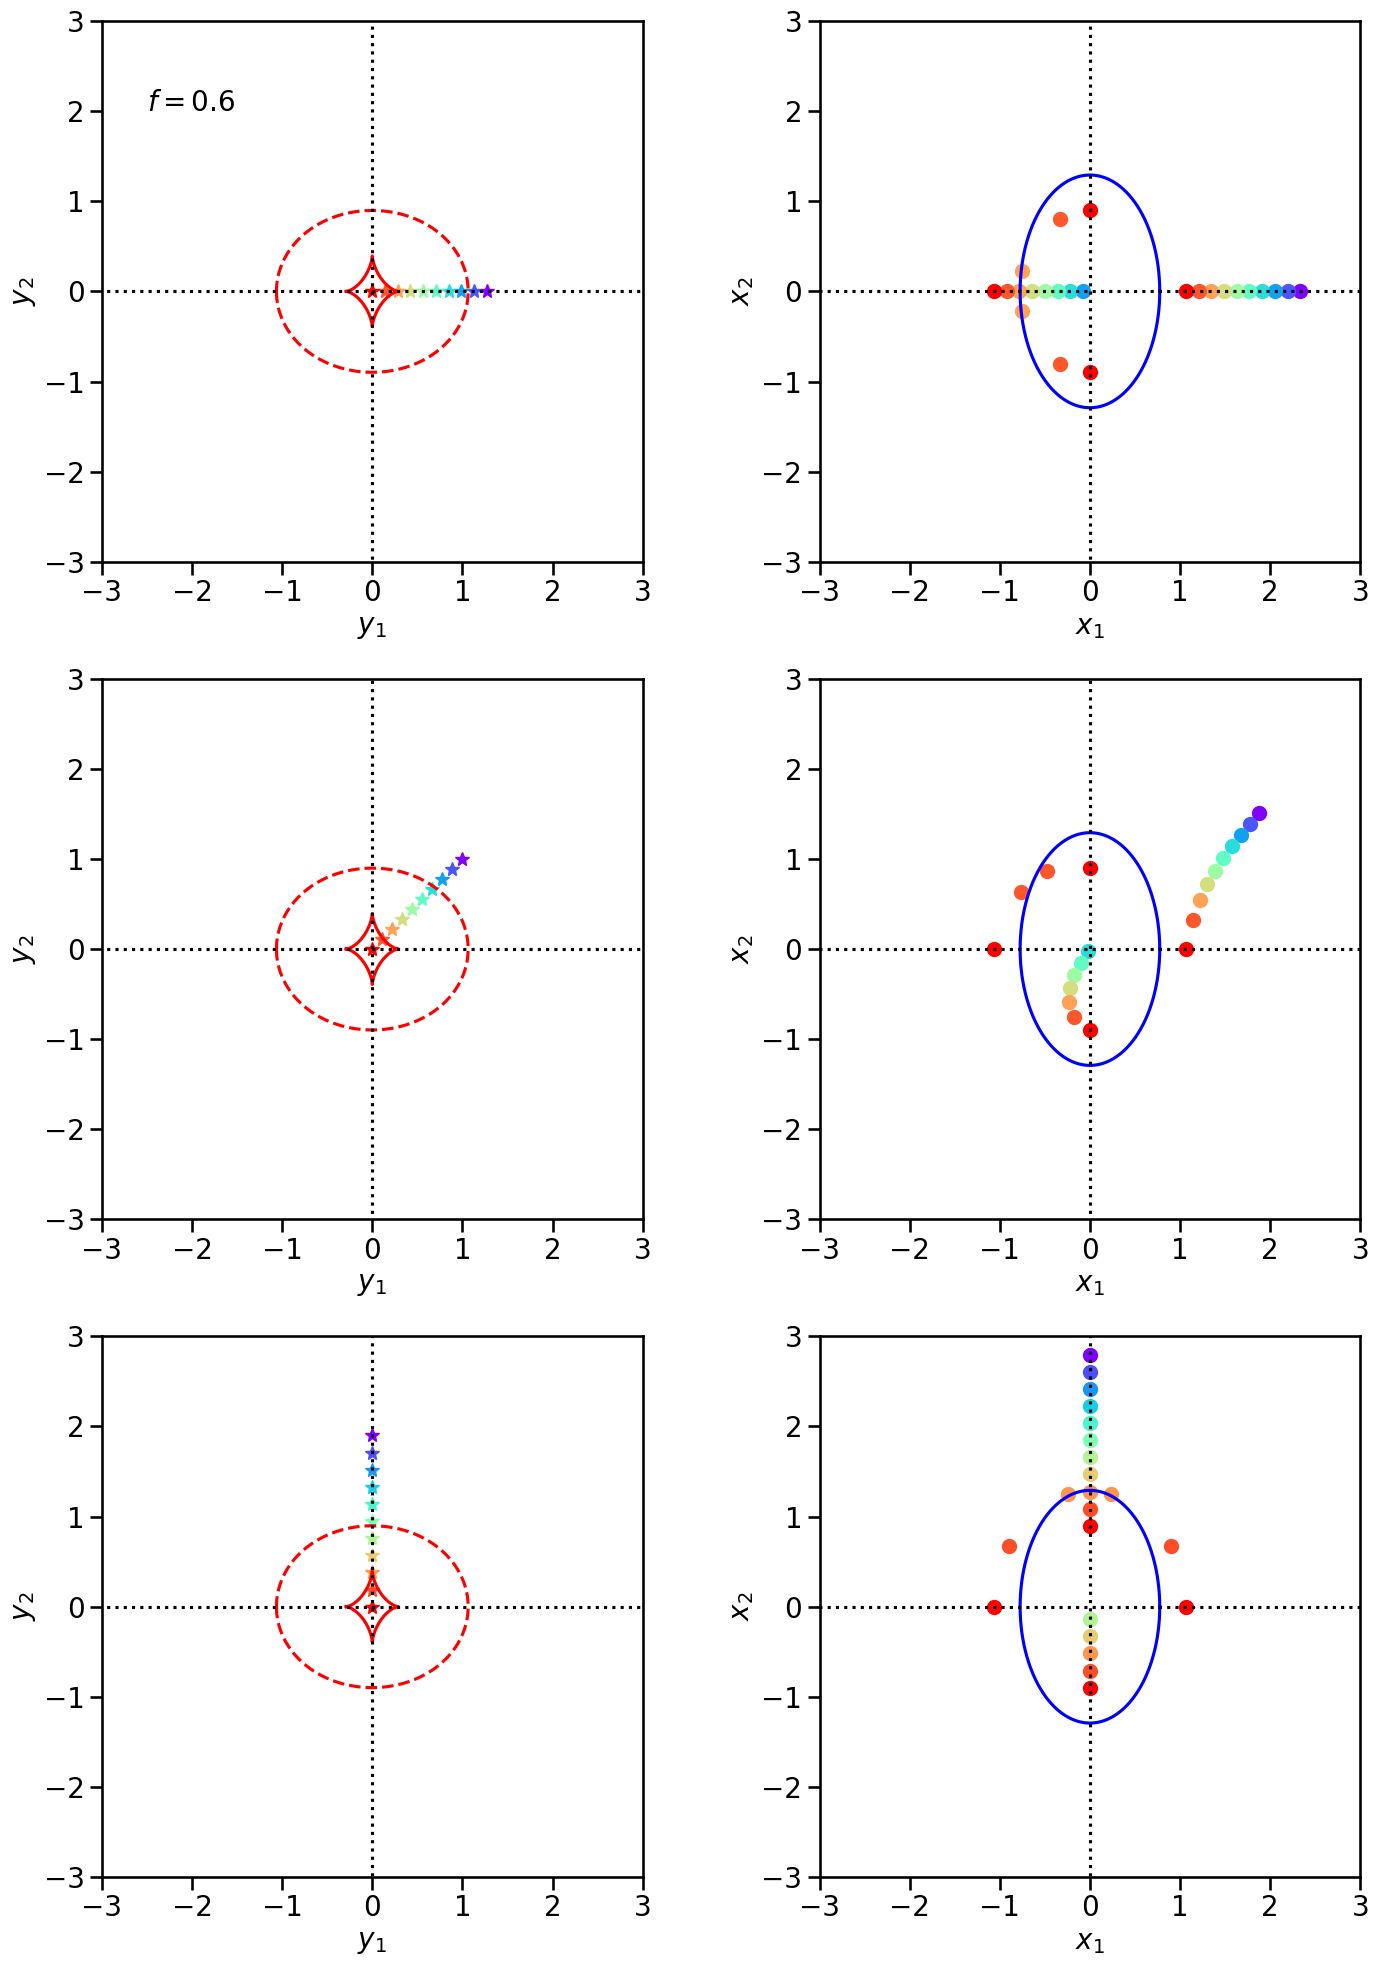

In [8]:
from matplotlib.pyplot import cm 

fig,ax=plt.subplots(3,2,figsize=(15,20))
f=0.6
sie=sie_lens(co,f=f)

# source on the y1 axis, moving from outside the cut towards the center of the lens
y1=np.linspace(1.27,0,10)
y2=np.zeros(y1.size)

color=iter(cm.rainbow(np.linspace(0,1,y1.size)))
for i in range(y1.size):
    c=next(color)
    x,phi=sie.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)

    x1_ima=x*np.cos(phi)
    x2_ima=x*np.sin(phi)
    
    ax[0,0].plot(y1[i],y2[i],'*',markersize=10,color=c)
    ax[0,1].plot(x1_ima,x2_ima,'o',markersize=10,color=c)

# source on the diagonal, moving from outside the cut towards the center of the lens
y1=np.linspace(1.0,0,10)
y2=y1

color=iter(cm.rainbow(np.linspace(0,1,y1.size)))
for i in range(y1.size):
    c=next(color)
    x,phi=sie.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)

    x1_ima=x*np.cos(phi)
    x2_ima=x*np.sin(phi)
    
    ax[1,0].plot(y1[i],y2[i],'*',markersize=10,color=c)
    ax[1,1].plot(x1_ima,x2_ima,'o',markersize=10,color=c)

# source on the y2 axis, moving from outside the cut towards the center of the lens
y2=np.linspace(1.9,0,11)
y1=np.zeros(y2.size)

color=iter(cm.rainbow(np.linspace(0,1,y1.size)))
for i in range(y1.size):
    c=next(color)
    x,phi=sie.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)

    x1_ima=x*np.cos(phi)
    x2_ima=x*np.sin(phi)
    
    ax[2,0].plot(y1[i],y2[i],'*',markersize=10,color=c)
    ax[2,1].plot(x1_ima,x2_ima,'o',markersize=10,color=c)
    
y1_cut,y2_cut=sie.cut()
y1_cau,y2_cau=sie.tan_caustic()
x1_cc,x2_cc=sie.tan_cc()

for i in range(3):
    ax[i,1].set_xlim([-3,3])
    ax[i,1].set_ylim([-3,3])
    ax[i,0].set_xlim([-3,3])
    ax[i,0].set_ylim([-3,3])
    ax[i,0].plot(y1_cut,y2_cut,'--',color='red')
    ax[i,0].plot(y1_cau,y2_cau,'-',color='red')
    ax[i,1].plot(x1_cc,x2_cc,'-',color='blue')
    ax[i,1].set_xlabel('$x_1$',fontsize=20)
    ax[i,1].set_ylabel('$x_2$',fontsize=20)
    ax[i,0].set_xlabel('$y_1$',fontsize=20)
    ax[i,0].set_ylabel('$y_2$',fontsize=20)
    showaxes(ax[i,0])
    showaxes(ax[i,1])

for i in range(3):
    for j in range(2):
        ax[i,j].xaxis.set_tick_params(labelsize=20)
        ax[i,j].yaxis.set_tick_params(labelsize=20)
        ax[i,j].set_aspect('equal')
    


ax[0,0].text(-2.5,2,'$f=$'+str(f),fontsize=20)
plt.tight_layout()
fig.savefig('sie_images_f'+str(f)+'.png')

The examples shown so far illustrate that in the case $f<f_0$:

* a source outside the cut always produces one image;

* inside the cut, but outside the caustic, it produces two images. The image multiplicity increases by one only because of the singularity at the center of the lens

* inside the caustic, it produces four images (thus, the multiplicity changes by two when crossing the caustic)

For $f>f_0$, the upper and the lower cusps of the caustic become "naked". The regions outside the cut but inside the caustic have multiplicity three. In this case, the lens can produce one, two, three, or four images. Check this out in the example below.

Some comments on the magnification and parity:

* $\mu$ is 

$$
\mu=\frac{1}{1-2\kappa} \;,
$$

meaning that $\mu>0$ for $\kappa<0.5$. Therefore, the parity of the images is positive outside the critical line, negative otherwise.
* the magnification of the images forming near the center of the lens is very small $|\mu|\sim 0$, being $\kappa$ divergent
* the magnification of the images near the critical line is divergent, of course...

Magnification and distortion are better understood using extended sources. In the examples below, we implement the reconstruction of the images of a circular source. The code can be changed to see how the results are affected by the size of the source or by its shape. 

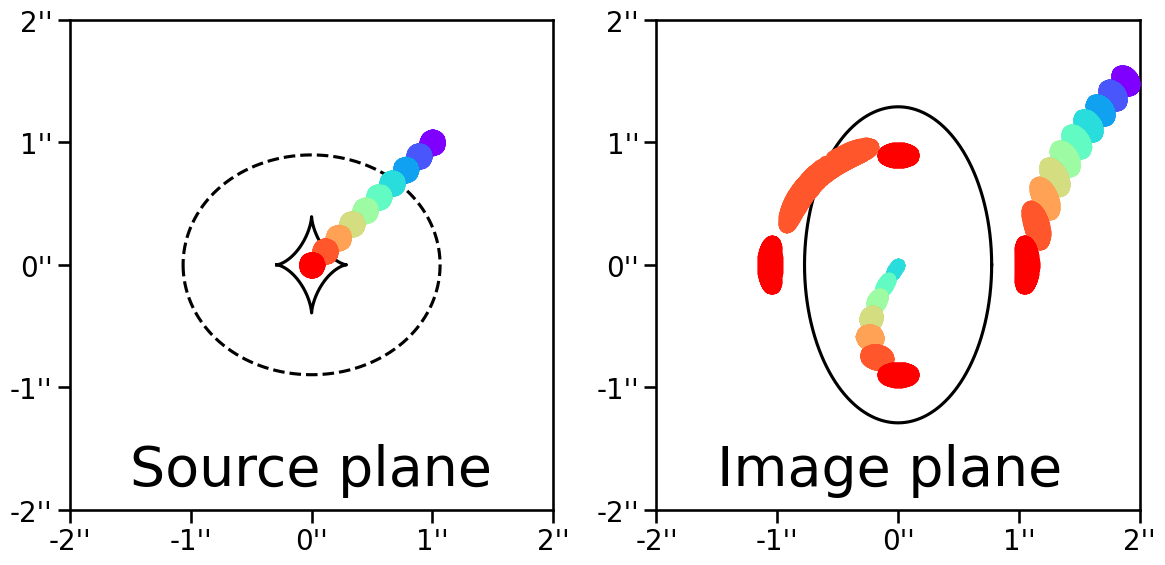

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,6))

y1c=np.linspace(1.0,0,10)
y2c=y1c
rs=0.05
f=0.6
sie=sie_lens(co,f=f)

color=iter(cm.rainbow(np.linspace(0,1,y1c.size)))


for j in range(y1c.size):
    c=next(color)
    y1,y2=sie.ext_source(y1c[j],y2c[j],rs)
    ax[0].plot(y1,y2,'.',color=c,  markersize=17, zorder=3)
    
    x,phi=sie.ext_image(y1c[j],y2c[j],rs)
    x1=x*np.cos(phi)
    x2=x*np.sin(phi)
    ax[1].plot(x1,x2,'.',color=c,  markersize=17, zorder=3)

ax[0].plot(y1_cut,y2_cut,'--',color='black', zorder=2)
ax[0].plot(y1_cau,y2_cau,'-',color='black', zorder=2)
ax[1].plot(x1_cc,x2_cc,'-',color='black', zorder=2)
ax[0].text(-1.5, -1.8, s='Source plane', fontsize=40)
ax[1].text(-1.5, -1.8, s='Image plane', fontsize=40)

ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[1].set_ylim(-2, 2)

ticks = [-2, -1, 0, 1, 2]
tick_labels = [f"{t}''" for t in ticks]

for axis in ax:
    axis.set_xticks(ticks)
    axis.set_xticklabels(tick_labels, fontsize=20)
    axis.set_yticks(ticks)
    axis.set_yticklabels(tick_labels, fontsize=20)

#ax[1].set_xlabel('$x_1$',fontsize=20)
#ax[1].set_ylabel('$x_2$',fontsize=20)
#ax[0].set_xlabel('$y_1$',fontsize=20)
#ax[0].set_ylabel('$y_2$',fontsize=20)

plt.tight_layout()
fig.savefig('sie_extimages.pdf')